# Определение оттока клиентов в телеком  
## Задача - построить модель прогнозирующую отток клиента для компании "Ниединогоразрыва.ком".

#### Импортируем необходимые модули

In [18]:
import pandas as pd
import numpy as np
import datetime
from datetime import date
import time
import phik

import matplotlib as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px 
import plotly.graph_objects as go
from os import path

from scipy import stats as st
import math as mth
from xgboost import  XGBClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn import set_config
from sklearn.utils import shuffle
from numpy.random import RandomState
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline as sk_Pipeline
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer

from catboost import Pool, CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)

In [19]:

path_local = '/Users/jullia/Downloads/final_provider/'

if path.exists(path_local):
    contracts = pd.read_csv(path_local +'contract.csv')
    internet  = pd.read_csv(path_local + 'internet.csv')
    personal = pd.read_csv(path_local +'personal.csv')
    phone = pd.read_csv(path_local +'phone.csv')
else:
    path_train = '/datasets/final_provider/'
    contracts = pd.read_csv(path_train + 'contract.csv')
    internet =  pd.read_csv(path_train + 'internet.csv')
    personal = pd.read_csv(path_train + 'personal.csv')
    phone = pd.read_csv(path_train + 'phone.csv')


In [20]:
contracts.head(20)

customerID   BeginDate              EndDate            Type  \
0   7590-VHVEG  2020-01-01                   No  Month-to-month   
1   5575-GNVDE  2017-04-01                   No        One year   
2   3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3   7795-CFOCW  2016-05-01                   No        One year   
4   9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   
5   9305-CDSKC  2019-03-01  2019-11-01 00:00:00  Month-to-month   
6   1452-KIOVK  2018-04-01                   No  Month-to-month   
7   6713-OKOMC  2019-04-01                   No  Month-to-month   
8   7892-POOKP  2017-07-01  2019-11-01 00:00:00  Month-to-month   
9   6388-TABGU  2014-12-01                   No        One year   
10  9763-GRSKD  2019-01-01                   No  Month-to-month   
11  7469-LKBCI  2018-10-01                   No        Two year   
12  8091-TTVAX  2015-04-01                   No        One year   
13  0280-XJGEX  2015-09-01  2019-10-01 00:00:00  Month-to-month   
14  5129-JLPIS  2018-01-01                   No  Month-to-month   
15  3655-SNQYZ  2014-05-01                   No        Two year   
16  8191-XWSZG  2015-10-01                   No        One year   
17  9959-WOFKT  2014-03-01                   No        Two year   
18  4190-MFLUW  2019-01-01  2019-11-01 00:00:00  Month-to-month   
19  4183-MYFRB  2018-05-01                   No  Month-to-month   

   PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0               Yes           Electronic check          29.850        29.85  
1                No               Mailed check          56.950       1889.5  
2               Yes               Mailed check          53.850       108.15  
3                No  Bank transfer (automatic)          42.300      1840.75  
4               Yes           Electronic check          70.700       151.65  
5               Yes           Electronic check          99.650        820.5  
6               Yes    Credit card (automatic)          89.100       1949.4  
7                No               Mailed check          29.750        301.9  
8               Yes           Electronic check         104.800      3046.05  
9                No  Bank transfer (automatic)          56.150      3487.95  
10              Yes               Mailed check          49.950       587.45  
11               No    Credit card (automatic)          18.950        326.8  
12               No    Credit card (automatic)         100.350       5681.1  
13              Yes  Bank transfer (automatic)         103.700       5036.3  
14              Yes           Electronic check         105.500      2686.05  
15               No    Credit card (automatic)         113.250      7895.15  
16               No               Mailed check          20.650      1022.95  
17               No  Bank transfer (automatic)         106.700      7382.25  
18               No    Credit card (automatic)          55.200       528.35  
19              Yes           Electronic check          90.050       1862.9

In [21]:
contracts[contracts['EndDate'] == 'No']['EndDate'].count()

5174

In [22]:
contracts.duplicated().sum()

0

In [23]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [24]:
fig = px.histogram(contracts, x='MonthlyCharges') 
fig.show()

In [25]:
contracts.describe()

MonthlyCharges
count        7043.000
mean           64.762
std            30.090
min            18.250
25%            35.500
50%            70.350
75%            89.850
max           118.750

#### Целевой признак в задаче - расторжение или сохранение контракта ('EndDate' == 'No'), в нашем датасете из 7043 клиентов 5174 или 73 процента прододжают быть клиентами компании - данные несбалансированы, придется учитывать этот моменет при подготовке признаков.    

In [26]:
internet.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [27]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [28]:
personal.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

In [29]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [30]:
phone.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

In [31]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


### Первое впечатление от данных  
1. Данные в 4 датасетах, в каждом из которых отсутствуют пропуски  
2. В каждом датасете разное количество наблюдений  
3. Только стобцы `MonthlyCharges` , `TotalCharges` содержат числовую информацию о  выручке с клиента 
4. Данные необходимо объединить в один датафрейм по ключу  `customerID`  

### Метрика качества проекта - ROC-AUC (устойчива к выбросам), дополнительно будем включать в расчеты F1 score и accuracy.

### План работы над проектом  
1. Загрузка, обработка, изучение данных:
    * Загрузка данных. Предобработка: переименование столбцов, проверка типов данных  и замена типов данных (`TofalCharges` бросается в глаза, замена строковых типов дат на дату)
    * Объединение 4 датасетов в один, буду приджойнивать к датасету `contracts` остальные датасеты, содержащие дополнительную информацию  
    * Обработка полученного датасета:
        - Работа с пропусками, возникшими в результате объединения таблиц
        - Создание новых признаков (длительность контракта, пр)
        - Удаление ненужных в построении модели признаков (номер контракта, прочее)
        - Проверка датасета на мультиколлинеарность, удаление столбцов с высокой корреляцией
        - Анализ данных на выбросы, обработка выбросов
2. Подготовка данных к моделированию:
    * Разбиение датасета на тренировочную и тестовую выборки в отношении 75:25  
    * Нормирование данных, при необходимости устранение дисбаланса классов на тренировочной выборке

3. Построение pipeline моделей  с настройкой гиперпараметров, кросс-валидацией; обучение моделей с испльзованием GridSerch:
    * Логистическая регрессия
    * Случайный лес
    * Xboost/CatBoost
    * VotingClassifier
4. Выбор лучшей модели и провека качества модели на тестовых данных  
5. Вывод и рекомендации по модели  





[1. Загрузка данных](#data_download)  
[2. Знакомство в с данными. Предобработка](#data_preprocessing)  
[3. Объединение данных в один датасет, подготовка данных для обучения](#merging)  
[4. Выбор моделей обучения](#model_celection)  
[5. Проверка модели на тестовой выборке](#model_testing)  
[6. Анализ значимости признаков](#feature_selection)  
[7. Выводы](#Conclusion)  


<a id='data_download'></a>
### 1. Загрузка данных

<a id='data_preprocessing'></a>
### 2. Знакомство в с данными. Предобработка

#### Датасет contracts

In [32]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Переименуем столбцы, изменим тип данных в столбцах `BeginDate`, `EndDate` на дату, в столбце `TotalChanges` - на float64 

In [33]:
contracts_columns = ['customer_id','begin_date', 'end_date','type', 'paperless_billing', 'payment_mode', 'monthly_charges', 'total_charges']

In [36]:
contracts.columns = contracts_columns

In [37]:
contracts.head()

customer_id  begin_date             end_date            type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  paperless_billing               payment_mode  monthly_charges total_charges  
0               Yes           Electronic check           29.850         29.85  
1                No               Mailed check           56.950        1889.5  
2               Yes               Mailed check           53.850        108.15  
3                No  Bank transfer (automatic)           42.300       1840.75  
4               Yes           Electronic check           70.700        151.65

In [38]:
contracts['begin_date'] = pd.to_datetime(contracts['begin_date'])

In [39]:
# Заменим все строковые знаечения 'No' в столбце 'end_data' на дату окончания сбора данных - 1 февраля 2020 года
contracts.loc[contracts['end_date']=='No', 'end_date'] = '2020-02-01'

In [40]:
contracts['end_date'] = pd.to_datetime(contracts['end_date'])

In [41]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_mode       7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 440.3+ KB


In [42]:
contracts['total_charges'] =  pd.to_numeric(contracts['total_charges'], errors='coerce')

In [43]:
contracts[contracts['total_charges'].isna()]

customer_id begin_date   end_date      type paperless_billing  \
488   4472-LVYGI 2020-02-01 2020-02-01  Two year               Yes   
753   3115-CZMZD 2020-02-01 2020-02-01  Two year                No   
936   5709-LVOEQ 2020-02-01 2020-02-01  Two year                No   
1082  4367-NUYAO 2020-02-01 2020-02-01  Two year                No   
1340  1371-DWPAZ 2020-02-01 2020-02-01  Two year                No   
3331  7644-OMVMY 2020-02-01 2020-02-01  Two year                No   
3826  3213-VVOLG 2020-02-01 2020-02-01  Two year                No   
4380  2520-SGTTA 2020-02-01 2020-02-01  Two year                No   
5218  2923-ARZLG 2020-02-01 2020-02-01  One year               Yes   
6670  4075-WKNIU 2020-02-01 2020-02-01  Two year                No   
6754  2775-SEFEE 2020-02-01 2020-02-01  Two year               Yes   

                   payment_mode  monthly_charges  total_charges  
488   Bank transfer (automatic)           52.550            NaN  
753                Mailed check           20.250            NaN  
936                Mailed check           80.850            NaN  
1082               Mailed check           25.750            NaN  
1340    Credit card (automatic)           56.050            NaN  
3331               Mailed check           19.850            NaN  
3826               Mailed check           25.350            NaN  
4380               Mailed check           20.000            NaN  
5218               Mailed check           19.700            NaN  
6670               Mailed check           73.350            NaN  
6754  Bank transfer (automatic)           61.900            NaN

Пропуски в столбце `total_charges` связаны с тем, что это новые клиенты, только заключившие контракт, не успевшие принести доход, заполним эти пропуски 0

In [44]:
contracts['total_charges'] = contracts['total_charges'].fillna(0)

In [45]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_mode       7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [46]:
contracts.head()

customer_id begin_date   end_date            type paperless_billing  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month               Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year                No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month               Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year                No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month               Yes   

                payment_mode  monthly_charges  total_charges  
0           Electronic check           29.850         29.850  
1               Mailed check           56.950       1889.500  
2               Mailed check           53.850        108.150  
3  Bank transfer (automatic)           42.300       1840.750  
4           Electronic check           70.700        151.650

In [47]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_mode       7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [48]:
# Добавим столбец с длительностью контракта в месяцах
contracts['contract_length_mnths'] = (contracts['end_date'] - contracts['begin_date']).dt.days/ 30

In [49]:
# добавим год начала контракта
contracts['begin_year'] = contracts['begin_date'].dt.year

In [50]:
# добавим месяц начала контракта
contracts['begin_month'] = contracts['begin_date'].dt.month

In [51]:
contracts.head()

customer_id begin_date   end_date            type paperless_billing  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month               Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year                No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month               Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year                No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month               Yes   

                payment_mode  monthly_charges  total_charges  \
0           Electronic check           29.850         29.850   
1               Mailed check           56.950       1889.500   
2               Mailed check           53.850        108.150   
3  Bank transfer (automatic)           42.300       1840.750   
4           Electronic check           70.700        151.650   

   contract_length_mnths  begin_year  begin_month  
0                  1.033        2020            1  
1                 34.533        2017            4  
2                  2.033        2019           10  
3                 45.700        2016            5  
4                  2.033        2019            9

In [52]:
# Добавим целевой столбец 'quit' - являтеся ли пользователь действующим клиентом компании (0) или ушедшим (1):
contracts.loc[contracts['end_date']== np.datetime64('2020-02-01'), 'quit'] = 0

In [53]:
contracts.loc[contracts['end_date'] != np.datetime64('2020-02-01'), 'quit'] = 1

In [54]:
contracts['quit'] = contracts['quit'].astype(int)

In [55]:
contracts.head()

customer_id begin_date   end_date            type paperless_billing  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month               Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year                No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month               Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year                No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month               Yes   

                payment_mode  monthly_charges  total_charges  \
0           Electronic check           29.850         29.850   
1               Mailed check           56.950       1889.500   
2               Mailed check           53.850        108.150   
3  Bank transfer (automatic)           42.300       1840.750   
4           Electronic check           70.700        151.650   

   contract_length_mnths  begin_year  begin_month  quit  
0                  1.033        2020            1     0  
1                 34.533        2017            4     0  
2                  2.033        2019           10     1  
3                 45.700        2016            5     0  
4                  2.033        2019            9     1

In [56]:
#проверим на дубликаты, и выбросы
contracts.duplicated().sum()

0

In [57]:
fig = px.box(contracts, x = 'total_charges', title='Размах суммарных расходов')

fig.show()

Выбросов нет, большая часть клиентов приносит до 4 тыс рублей, а медианный доход около 1400 руб

In [58]:
fig = px.histogram(contracts, x='contract_length_mnths', color ='quit', title='Распределение длительности контрактов в месяцах')
fig.show()

In [59]:
fig1 = px.histogram(contracts.query('quit==1'), x='contract_length_mnths', title='Распределение ушедших клиентов по длине контракта')
fig2 = px.histogram(contracts.query('quit==0'), x='contract_length_mnths', title = 'Распределение активных клиентов по длине контракта' )
fig1.show()
fig2.show()

Видим, что большинство тех, кто уходит, уходит быстро, через 1-3 месяца, а среди активных клиентов много старожилов, которые в компании более 5 лет 

#### Датасет internet

In [60]:
internet.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [61]:
inter_columns = ['customer_id', 'internet_service','online_security','online_backup','device_protection','tech_support','streaming_tv','streaming_movies']

In [62]:
internet.columns = inter_columns

In [63]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [64]:
internet.duplicated().sum()

0

In [65]:
internet['internet_service'].value_counts()

Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

В датасете `internet` меньше наблюдений, чем в contracts, не все пользовтели имеют контракт с интернет-услугами, в датасете нет пропусков и дубликатов, пользователи почти поровну распределяются по виду интренет услуг (Fiber optic и  DSL)

#### Датасет personal

In [66]:
personal.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

In [67]:
person_columns = ['customer_id','gender','senior_citizen','partner','dependants']

In [68]:
personal.columns = person_columns

In [69]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependants      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [70]:
personal.duplicated().sum()

0

In [71]:
personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [72]:
fig = px.bar(personal.groupby('gender', as_index=False).agg({'customer_id':'nunique'})\
    .rename(columns={'customer_id':'customers'}), y='customers', x='gender', title='Распределение пользователей по полу')
fig.show()

In [73]:
personal['dependants'].value_counts()

No     4933
Yes    2110
Name: dependants, dtype: int64

In [74]:
fig = px.bar(personal.groupby('dependants', as_index=False).agg({'customer_id':'nunique'})\
    .rename(columns={'customer_id':'customers'}), y='customers', x='dependants', title='Распределение пользователей по наличию иждивенцев')
fig.show()

In [75]:
personal['partner'].value_counts()

No     3641
Yes    3402
Name: partner, dtype: int64

In [58]:
fig = px.bar(personal.groupby('partner', as_index=False).agg({'customer_id':'nunique'})\
    .rename(columns={'customer_id':'customers'}), y='customers', x='partner', title='Распределение пользователей по наличию партнера')
fig.show()

In [76]:
personal['senior_citizen'].value_counts()

0    5901
1    1142
Name: senior_citizen, dtype: int64

In [77]:
fig = px.bar(personal.groupby('senior_citizen', as_index=False).agg({'customer_id':'nunique'})\
    .rename(columns={'customer_id':'customers'}), y='customers', x='senior_citizen',\
         title='Распределение пользователей на пользователей до и после пенсионного возраста')
fig.show()

Среди клинтов примерно поровну мужчин и женщин, имеющих и не имеющих парнтеров, преобладают свободные от иждевенцев и не пенсионеры  

Количество строк в датасете соответствует `contracts`, нет дубликатов и пропусков

#### Датасет phone

In [78]:
phone.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

In [79]:
phone = phone.rename(columns={'customerID':'customer_id','MultipleLines':'multiple_lines'})

In [80]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [81]:
phone.duplicated().sum()

0

In [82]:
phone['multiple_lines'].value_counts()

No     3390
Yes    2971
Name: multiple_lines, dtype: int64

In [83]:
fig = px.bar(phone.groupby('multiple_lines', as_index=False).agg({'customer_id':'nunique'})\
    .rename(columns={'customer_id':'customers'}), y='customers', x='multiple_lines',\
         title='Распределение пользователей по наличию мультиканальной телефонного связи')
fig.show()

В датасете `phone` меньше строк, не на всех пользоателей есть информация по нескольким телефонным лииниям, дубликатов и пропусков нет, примерно половина пользовтелей имеет несколько телефонных линий

<a id='merging'></a>
### 3. Объединение данных в один датасет, подготовка данных для обучения

In [84]:
#Объединим датасеты в один, приджойнив остальные датасеты слева к датасету contracts
merged = contracts\
    .merge(personal, on='customer_id', how='left' )\
    .merge(internet, on='customer_id', how='left')\
    .merge(phone, on='customer_id', how='left')

In [85]:
merged.head()

customer_id begin_date   end_date            type paperless_billing  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month               Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year                No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month               Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year                No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month               Yes   

                payment_mode  monthly_charges  total_charges  \
0           Electronic check           29.850         29.850   
1               Mailed check           56.950       1889.500   
2               Mailed check           53.850        108.150   
3  Bank transfer (automatic)           42.300       1840.750   
4           Electronic check           70.700        151.650   

   contract_length_mnths  begin_year  ...  partner  dependants  \
0                  1.033        2020  ...      Yes          No   
1                 34.533        2017  ...       No          No   
2                  2.033        2019  ...       No          No   
3                 45.700        2016  ...       No          No   
4                  2.033        2019  ...       No          No   

  internet_service  online_security online_backup device_protection  \
0              DSL               No           Yes                No   
1              DSL              Yes            No               Yes   
2              DSL              Yes           Yes                No   
3              DSL              Yes            No               Yes   
4      Fiber optic               No            No                No   

  tech_support streaming_tv streaming_movies multiple_lines  
0           No           No               No            NaN  
1           No           No               No             No  
2           No           No               No             No  
3          Yes           No               No            NaN  
4           No           No               No             No  

[5 rows x 24 columns]

In [86]:
merged.isna().sum().sort_values(ascending=False)

streaming_movies         1526
streaming_tv             1526
tech_support             1526
device_protection        1526
online_backup            1526
online_security          1526
internet_service         1526
multiple_lines            682
begin_date                  0
dependants                  0
partner                     0
senior_citizen              0
customer_id                 0
quit                        0
begin_month                 0
begin_year                  0
contract_length_mnths       0
total_charges               0
monthly_charges             0
payment_mode                0
paperless_billing           0
type                        0
end_date                    0
gender                      0
dtype: int64

In [87]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customer_id            7043 non-null   object        
 1   begin_date             7043 non-null   datetime64[ns]
 2   end_date               7043 non-null   datetime64[ns]
 3   type                   7043 non-null   object        
 4   paperless_billing      7043 non-null   object        
 5   payment_mode           7043 non-null   object        
 6   monthly_charges        7043 non-null   float64       
 7   total_charges          7043 non-null   float64       
 8   contract_length_mnths  7043 non-null   float64       
 9   begin_year             7043 non-null   int64         
 10  begin_month            7043 non-null   int64         
 11  quit                   7043 non-null   int64         
 12  gender                 7043 non-null   object        
 13  sen

Пропуски в итоговом датасете связаны с отсутсвием данных - отсутствием у клиента данных услуг, считаю правильным заполнить их значением 'No'

In [88]:
merged = merged.fillna('No')

In [89]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customer_id            7043 non-null   object        
 1   begin_date             7043 non-null   datetime64[ns]
 2   end_date               7043 non-null   datetime64[ns]
 3   type                   7043 non-null   object        
 4   paperless_billing      7043 non-null   object        
 5   payment_mode           7043 non-null   object        
 6   monthly_charges        7043 non-null   float64       
 7   total_charges          7043 non-null   float64       
 8   contract_length_mnths  7043 non-null   float64       
 9   begin_year             7043 non-null   int64         
 10  begin_month            7043 non-null   int64         
 11  quit                   7043 non-null   int64         
 12  gender                 7043 non-null   object        
 13  sen

In [88]:
#Удалим столбцы не нужные для анализа: customer_id, begin_date, end_date

In [90]:
merged = merged.drop(['customer_id', 'begin_date','end_date'], axis=1)

После длительных экспериментов со столбцами, пришла к выводу, что логистическая регрессия реботает не очень хорошо, корреляция не особельно сильно влияет на качество моделей, приняла решение максимально оставить  столбцы 

In [76]:

#Проверим корреляюцию признаков
#correlation = merged.phik_matrix()

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'contract_length_mnths', 'begin_year', 'begin_month', 'quit', 'senior_citizen']


In [77]:
#correlation[correlation > 0.7].fillna('')

type paperless_billing payment_mode monthly_charges  \
type                  1.000                                                  
paperless_billing                       1.000                                
payment_mode                                         1.000                   
monthly_charges                                                      1.000   
total_charges                                                        0.763   
contract_length_mnths                                                        
begin_year                                                                   
begin_month                                                                  
quit                                                                         
gender                                                                       
senior_citizen                                                               
partner                                                                      
dependants                                                                   
internet_service                                                     0.919   
online_security                                                              
online_backup                                                                
device_protection                                                            
tech_support                                                                 
streaming_tv                                                         0.835   
streaming_movies                                                     0.833   
multiple_lines                                                               

                      total_charges contract_length_mnths begin_year  \
type                                                                   
paperless_billing                                                      
payment_mode                                                           
monthly_charges               0.763                                    
total_charges                 1.000                 0.842      0.733   
contract_length_mnths         0.842                 1.000      0.927   
begin_year                    0.733                 0.927      1.000   
begin_month                                                            
quit                                                                   
gender                                                                 
senior_citizen                                                         
partner                                                                
dependants                                                             
internet_service                                                       
online_security                                                        
online_backup                                                          
device_protection                                                      
tech_support                                                           
streaming_tv                                                           
streaming_movies                                                       
multiple_lines                                                         

                      begin_month  quit gender  ... partner dependants  \
type                                            ...                      
paperless_billing                               ...                      
payment_mode                                    ...                      
monthly_charges                                 ...                      
total_charges                                   ...                      
contract_length_mnths                           ...                      
begin_year                                      ...                      
begin_month                 1.000               ...                      
quit                              1.000         ...    

In [78]:
# Можно удалить один из двух столбцов, корреляция которых выше 0.7, удалим столбцы 'total_charges', 'streaming_movies', 'streaming_tv', 'contract_length_mnths' ,
# 'internet_service'
#merged = merged.drop(columns=['streaming_movies','streaming_tv','total_charges','internet_service','contract_length_mnths'], axis=1)



In [91]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type                   7043 non-null   object 
 1   paperless_billing      7043 non-null   object 
 2   payment_mode           7043 non-null   object 
 3   monthly_charges        7043 non-null   float64
 4   total_charges          7043 non-null   float64
 5   contract_length_mnths  7043 non-null   float64
 6   begin_year             7043 non-null   int64  
 7   begin_month            7043 non-null   int64  
 8   quit                   7043 non-null   int64  
 9   gender                 7043 non-null   object 
 10  senior_citizen         7043 non-null   int64  
 11  partner                7043 non-null   object 
 12  dependants             7043 non-null   object 
 13  internet_service       7043 non-null   object 
 14  online_security        7043 non-null   object 
 15  onli

In [92]:
# Чтобы избежать подсматривания, удалим столбец begin_gear
features = merged.drop(columns=['quit','begin_year'], axis=1)
target = merged['quit']

In [93]:
features.head()

type paperless_billing               payment_mode  \
0  Month-to-month               Yes           Electronic check   
1        One year                No               Mailed check   
2  Month-to-month               Yes               Mailed check   
3        One year                No  Bank transfer (automatic)   
4  Month-to-month               Yes           Electronic check   

   monthly_charges  total_charges  contract_length_mnths  begin_month  gender  \
0           29.850         29.850                  1.033            1  Female   
1           56.950       1889.500                 34.533            4    Male   
2           53.850        108.150                  2.033           10    Male   
3           42.300       1840.750                 45.700            5    Male   
4           70.700        151.650                  2.033            9  Female   

   senior_citizen partner dependants internet_service online_security  \
0               0     Yes         No              DSL              No   
1               0      No         No              DSL             Yes   
2               0      No         No              DSL             Yes   
3               0      No         No              DSL             Yes   
4               0      No         No      Fiber optic              No   

  online_backup device_protection tech_support streaming_tv streaming_movies  \
0           Yes                No           No           No               No   
1            No               Yes           No           No               No   
2           Yes                No           No           No               No   
3            No               Yes          Yes           No               No   
4            No                No           No           No               No   

  multiple_lines  
0             No  
1             No  
2             No  
3             No  
4             No

In [94]:
# Разделим данные на обучающую и тестовую выборку в отношении 75:25
features_train, features_test, target_train, target_test \
    = train_test_split(features, target,  train_size=0.75, random_state=101022, shuffle=target)

In [95]:
(features_train.shape, target_train.shape)

((5282, 19), (5282,))

In [96]:
(features_test.shape, target_test.shape)

((1761, 19), (1761,))

#### Создадим pipeline

In [97]:
state = RandomState(101022)

In [98]:
classifiers = [
  LogisticRegression(random_state=state),
  RandomForestClassifier(random_state=state),
  XGBClassifier(random_state=state),
  AdaBoostClassifier(),
  CatBoostClassifier(eval_metric='AUC')
]

In [99]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)

In [100]:
class_prarms = [
    { 'class__solver' : ['lbfgs', 'liblinear'],'class__penalty' :['l1','l2','none'], 'class__C': np.arange(0.5,1.5,0.25), 'class__fit_intercept' : [True, False] },
    {'class__max_features': ['auto','log2','sqrt', 'None'],'class__criterion' : ['gini', 'log_loss', 'entropy'], 'class__n_estimators' : range(10,1000,10), 'class__max_depth' : range(1,50), 'class__min_samples_split': range(1,10), 'class__min_samples_leaf': range(1,10)},
    {'class__eta': np.arange(0.01, 0.2, 0.01), 'class__max_depth': range(3,20), 'class__gamma' : np.arange(0,1,0.001),'class__learning_rate': np.arange(0.01, 1, 0.001), 'class__booster':['gbtree','gblinear'], 'class__n_estimators': range(10,1000,5)},
    {'class__n_estimators' : range(10,1000,10), 'class__learning_rate' : np.arange(0.1, 1, 0.01),'class__algorithm' : ['SAMME','SAMME.R'] },
    {'class__learning_rate': np.arange(0,1,0.001), 'class__iterations': range(5,100,1), 'class__depth': range(2,20), 'class__l2_leaf_reg':range(2,11), 'class__random_strength': range(0,11)}
]
cv = KFold(n_splits=10, shuffle=True, random_state=state)

In [101]:
features.head()

type paperless_billing               payment_mode  \
0  Month-to-month               Yes           Electronic check   
1        One year                No               Mailed check   
2  Month-to-month               Yes               Mailed check   
3        One year                No  Bank transfer (automatic)   
4  Month-to-month               Yes           Electronic check   

   monthly_charges  total_charges  contract_length_mnths  begin_month  gender  \
0           29.850         29.850                  1.033            1  Female   
1           56.950       1889.500                 34.533            4    Male   
2           53.850        108.150                  2.033           10    Male   
3           42.300       1840.750                 45.700            5    Male   
4           70.700        151.650                  2.033            9  Female   

   senior_citizen partner dependants internet_service online_security  \
0               0     Yes         No              DSL              No   
1               0      No         No              DSL             Yes   
2               0      No         No              DSL             Yes   
3               0      No         No              DSL             Yes   
4               0      No         No      Fiber optic              No   

  online_backup device_protection tech_support streaming_tv streaming_movies  \
0           Yes                No           No           No               No   
1            No               Yes           No           No               No   
2           Yes                No           No           No               No   
3            No               Yes          Yes           No               No   
4            No                No           No           No               No   

  multiple_lines  
0             No  
1             No  
2             No  
3             No  
4             No

In [102]:
cat_col = ['paperless_billing','payment_mode','gender','senior_citizen',\
    'partner','dependants','online_backup','online_security','device_protection',\
    'tech_support', 'multiple_lines','type','streaming_movies','streaming_tv','internet_service']

In [103]:
m_col = ['monthly_charges', 'begin_month','total_charges','contract_length_mnths']

In [104]:
features.columns

Index(['type', 'paperless_billing', 'payment_mode', 'monthly_charges',
       'total_charges', 'contract_length_mnths', 'begin_month', 'gender',
       'senior_citizen', 'partner', 'dependants', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

In [105]:
t = [('cat', OneHotEncoder(), cat_col), ('num', StandardScaler(), m_col)]
col_transform = ColumnTransformer(transformers=t)


In [106]:
from scipy import rand


best_esimators = []
best_score = []
for i, classifier in enumerate(classifiers):
    steps = [
       ('prep',col_transform),
       ('smote', SMOTE(random_state=state)),
       ('selector', VarianceThreshold()),
       ('class', classifier)
    ]
    pipeline = Pipeline(steps)
    grid = RandomizedSearchCV(pipeline,class_prarms[i] , scoring=roc_auc_scorer, cv=cv, n_iter=10)
    grid.fit(features_train, target_train)
    print(classifier, grid.best_estimator_)
    best_esimators.append(grid.best_estimator_)
    best_score.append(grid.best_score_)
   

LogisticRegression(random_state=RandomState(MT19937) at 0x29FC0B040) Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['paperless_billing',
                                                   'payment_mode', 'gender',
                                                   'senior_citizen', 'partner',
                                                   'dependants',
                                                   'online_backup',
                                                   'online_security',
                                                   'device_protection',
                                                   'tech_support',
                                                   'multiple_lines', 'type',
                                                   'streaming_movies',
                                                   'streaming_tv',
                                              

In [107]:
best_score

[0.8481907372894947,
 0.8822920139041756,
 0.9940256995262338,
 0.8829621922548355,
 0.9897904241976407]

<a id='model_testing'></a>
### 5. Проверка моделей на тестовой выборке

In [108]:
from sklearn.metrics import accuracy_score


r_result = []
f_result = []
a_result = []
for estimator in best_esimators:
    estimator.fit(features_train, target_train)
    predicted = estimator.predict(features_test)
    r_score = roc_auc_score(target_test, predicted)
    accuracy = accuracy_score(target_test, predicted)
    f1 = f1_score(target_test, predicted)
    r_result.append(r_score)
    f_result.append(f1)
    a_result.append(accuracy)

0:	total: 6.6ms	remaining: 284ms
1:	total: 13.7ms	remaining: 287ms
2:	total: 20.2ms	remaining: 276ms
3:	total: 27.5ms	remaining: 275ms
4:	total: 33.5ms	remaining: 262ms
5:	total: 39.4ms	remaining: 250ms
6:	total: 45.8ms	remaining: 242ms
7:	total: 52.4ms	remaining: 236ms
8:	total: 59.7ms	remaining: 232ms
9:	total: 65.1ms	remaining: 221ms
10:	total: 71.1ms	remaining: 213ms
11:	total: 76.8ms	remaining: 205ms
12:	total: 83.4ms	remaining: 199ms
13:	total: 88.4ms	remaining: 189ms
14:	total: 95.1ms	remaining: 184ms
15:	total: 100ms	remaining: 175ms
16:	total: 107ms	remaining: 169ms
17:	total: 114ms	remaining: 165ms
18:	total: 120ms	remaining: 158ms
19:	total: 137ms	remaining: 164ms
20:	total: 200ms	remaining: 219ms
21:	total: 210ms	remaining: 210ms
22:	total: 215ms	remaining: 197ms
23:	total: 222ms	remaining: 185ms
24:	total: 229ms	remaining: 174ms
25:	total: 236ms	remaining: 163ms
26:	total: 248ms	remaining: 156ms
27:	total: 254ms	remaining: 145ms
28:	total: 264ms	remaining: 137ms
29:	total:

In [111]:
estimator = best_esimators[2]
estimator.fit(features_train, target_train)
predicted = estimator.predict(features_test)
r_score = roc_auc_score(target_test, predicted)
accuracy = accuracy_score(target_test, predicted)
f1 = f1_score(target_test, predicted)

In [112]:
result_data_one = pd.DataFrame({'Модель': classifiers[2], 'roc_auc': [r_score], 'accuracy': [accuracy], 'f1': [f1]})

In [113]:
result_data_one

Модель  roc_auc  accuracy    f1
0  XGBClassifier(base_score=None, booster=None, c...    0.973     0.985 0.972

In [114]:
best_esimators[2]

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['paperless_billing',
                                                   'payment_mode', 'gender',
                                                   'senior_citizen', 'partner',
                                                   'dependants',
                                                   'online_backup',
                                                   'online_security',
                                                   'device_protection',
                                                   'tech_support',
                                                   'multiple_lines', 'type',
                                                   'streaming_movies',
                                                   'streaming_tv',
                                                   'internet_service']),
                                                 ('num', StandardScaler(),
                                                  ['monthly_char...
                               eval_metric=None, gamma=0.176, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.8209999999999993, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=4, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=560, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=189388003,
                               reg_alpha=0, ...))])

In [120]:
best_esimators[2][3]

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.13,
              eval_metric=None, gamma=0.176, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.8209999999999993, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=4, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=560, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=189388003, reg_alpha=0, ...)

<a id='feature_selection'></a>
### 6. Анализ значимости признаков

In [132]:
features_train_enc = pd.get_dummies(features_train, drop_first=True)

In [133]:
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train_enc)

[0.00852869 0.00777289 0.03311843 0.03208709 0.0106718  0.12677702
 0.16526222 0.01996835 0.00154618 0.0292342  0.00434801 0.00578295
 0.00344198 0.01267254 0.33205944 0.13433479 0.02163319 0.0035892
 0.00400021 0.00873483 0.00102305 0.02635324 0.0070597 ]


<AxesSubplot: >

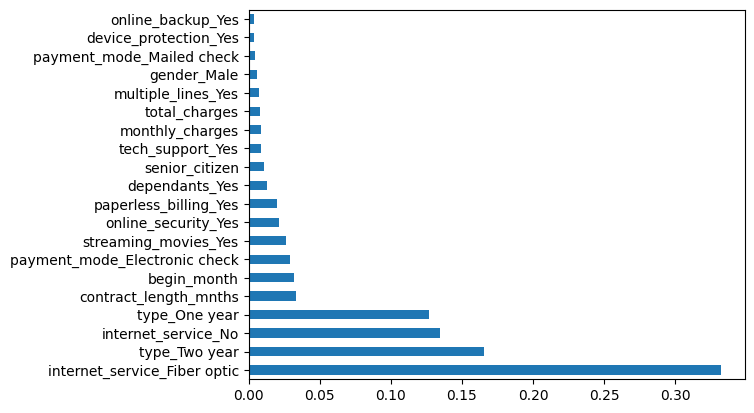

In [138]:
model = XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.13,
              eval_metric=None, gamma=0.176, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.8209999999999993, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=4, max_leaves=0,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=560, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=189388003, reg_alpha=0)
model.fit(features_train_scaled, target_train)
print(model.feature_importances_)
# plot
feat_importances = pd.Series(model.feature_importances_, index=features_train_enc.columns)
feat_importances.nlargest(20).plot(kind='barh')

Самыми важными признаками, повлиявшими на уход клиента, модель XGBoost назвала вид соедниения интренета, вид контракта, и отутствие интернет-контракта 

<a id='Conclusion'></a>
### 7.  Выводы


1. Провели обучение, настройку и проверку модели классификации для определения пользователей, которые готовы разорвать контркт с телекоммуникационной компанией  
2. Лучшей моделью по метрике `ROC-AUC` является `XGBoostClassifer`, roc-auc достигла на тестовой выборке `0.97`, accuracy и f1 мера также лушчие у этой модели   


# Отчет по проделанной работе


### Проведена работа по классификации пользователей телекоммуникационной компаини. 
Для классификации были отобраны 5 моделей, из которых наилучшие характеристики `ROC-AUC` получила модель `XGBoostClassifier`.  
Работа выполнена в соответсвии с первоначальным планом. Небольшие изменения касались состава моделей для обучения, мной было принято решение не использовать VotingClasifier из-за сложности его применения в pipeline, и добавить Catboost и AdaBoostClassifier.  
Работа над проектом была очень интересной, большая часть времени мной была потрачено на подбор гиперпараметров модели и на подготовку признаков. В начале я добавила только один дополнительный принзнак - время контракта в месяцах, потом избавилась от признаков с высокой корреляцией, но показатели качества модели были плохими, никакие эксперименты с гиперпараметрами не помогли. Тогда я решила добавить еще признаки - год начала и месяц начала контракта, а по совету тимлида я не стала удалять мультиколлинеарность, так как для многих моделей классификациии она не ухудшает качество прогнозов.  
Это позволило заметно улучить модель и добиться высоких результатов и на тестовой выборке.  
Сложности возникли также на этапе предобработки данных, по замечанию тимлида я внесла кодирование признаков в pipeline, что позволит в будущем проще добавлять новые признаки в модель, а также я больше внимания стала уделать проблеме подглядывания - по этой причине нельзя было оставить в признаках одновременно и год начала и длительность контракта. 
Замечания тимлида были понятными, очень помогла положительная обратная связь - то, что тимлид обращал внимание не только на проблемы, но и на то, что получилось хорошо. 


 